In [1]:
import numpy as np
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import TensorModel

from matplotlib import pyplot as plt
import os

/home/bxy/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
root = '/home/bxy/DDM_experiments/dw_DDM_original/result/' # **YOUR ROOT OF DENOISED DATA**
denoised_data = {}

noisy_data_path = '../data/HARDI150.nii.gz' #噪声数据路径
bvals_path = '../data/stanford_hardi.bval' #bval路径
bvecs_path = '../data/stanford_hardi.bvec' #bvec路径

data, affine = load_nifti(noisy_data_path)
# raw_max =  np.max(data, axis=(0,1,2), keepdims=True)
bvals, bvecs = read_bvals_bvecs(bvals_path, bvecs_path)

# non b0 mask
sel_b = bvals != 0
b0_size = 10

# create a new gradient table on non b0 directions
gtab = gradient_table(bvals[sel_b], bvecs[sel_b])
raw_gtab = gradient_table(bvals, bvecs)

# PLEASE DOUBLE CHECK THE PATH BELOW
# THE DENOISED DATA MUST CONTAIN B0 DIRETCIONS!!
denoised_data['NLM'], _ = load_nifti(root+'denoisy_nlm_D_61_700_2000_snr40.nii.gz')
denoised_data['MPPCA'], _ = load_nifti(root+'denoisy_mppca_D_1000_snr20_eddy.nii.gz')
denoised_data['DDM$^2$'], _ = load_nifti(root+'hardi_ori.nii.gz')
denoised_data['Patch2Self'], _ = load_nifti(root+'denoisy_patch2self_D_61_700_2000_snr40.nii.gz')
denoised_data['ECDM'], _ = load_nifti('./hardi_best.nii.gz')

# normalize denoised data
for k in denoised_data.keys():
    denoised_data[k] -= np.min(denoised_data[k], axis=(0,1), keepdims=True) + 1e-8
    denoised_data[k] /= np.max(denoised_data[k], axis=(0,1), keepdims=True)
    # denoised_data[k] = np.concatenate((data[:,:,:,:b0_size], denoised_data[k]), axis=-1)


print('Data loading done!')


/home/bxy/miniconda3/envs/torch/lib/python3.10/site-packages/dipy/core/gradients.py:332: UserWarning: b0_threshold (value: 50) is too low, increase your b0_threshold. It should be higher than the lowest b0 value (2000.0).
  warn("b0_threshold (value: {0}) is too low, increase your "


Data loading done!


In [27]:
import numpy as np
denoised_data['ECDM'] = np.pad(denoised_data['ECDM'], ((0,1), (0,0), (0,0), (0,0)), mode='wrap')
denoised_data['ECDM'].shape

(81, 106, 76, 31)

In [4]:
for k in denoised_data.keys():
    if np.isnan(denoised_data[k]).any():
        print(k, "contains NaN values.")

In [29]:
print('Computing brain mask...')
b0_mask, mask = median_otsu(data, vol_idx=[0])

print('Computing tensors...')
tenmodel = TensorModel(raw_gtab)
tensorfit = tenmodel.fit(data, mask=mask)

Computing brain mask...
Computing tensors...


Computing worst-case/best-case SNR using the corpus callosum...


/tmp/ipykernel_1170673/3481455549.py:41: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


(81, 106, 76)


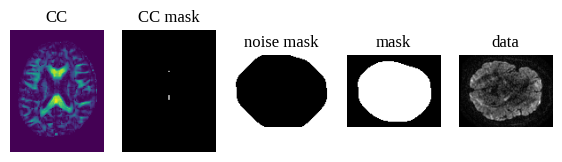

In [30]:
print('Computing worst-case/best-case SNR using the corpus callosum...')
from dipy.segment.mask import segment_from_cfa
from dipy.segment.mask import bounding_box

threshold = (0.6, 1, 0, 0.1, 0, 0.1)

CC_box = np.zeros_like(data[..., 0])

mins, maxs = bounding_box(mask)
mins = np.array(mins)
maxs = np.array(maxs)
diff = (maxs - mins) // 4
bounds_min = mins + diff
bounds_max = maxs - diff

CC_box[bounds_min[0]:bounds_max[0],
       bounds_min[1]:bounds_max[1],
       bounds_min[2]:bounds_max[2]] = 1

mask_cc_part, cfa = segment_from_cfa(tensorfit, CC_box, threshold,
                                     return_cfa=True)


import matplotlib.pyplot as plt

region = 40

# visualize the masks and ROI
fig = plt.figure('Corpus callosum segmentation')
plt.subplot(1, 5, 1)
plt.title("CC")
plt.axis('off')
red = cfa[..., 0]
plt.imshow(np.rot90(red[...,region]))

plt.subplot(1, 5, 2)
plt.title("CC mask")
plt.axis('off')
plt.imshow(np.rot90(mask_cc_part[...,region]), cmap='gray')

from scipy.ndimage.morphology import binary_dilation
mask_noise = binary_dilation(mask, iterations=10)

mask_noise = ~mask_noise
print(mask_noise.shape)

plt.subplot(1, 5, 3)
plt.title("noise mask")
plt.axis('off')
plt.imshow(mask_noise[:,:,30], cmap='gray')

plt.subplot(1, 5, 4)
plt.title("mask")
plt.axis('off')
plt.imshow(mask[:,:,30], cmap='gray')


plt.subplot(1, 5, 5)
plt.title("data")
plt.axis('off')
plt.imshow(data[:,:,30,30], cmap='gray')

In [32]:
data = data[:,:,:,:31]
# data_normalized = data
# mask_cc_part = mask_cc_part[:,:,:31]
# mask_noise = mask_noise[:,:,:31]

In [33]:
# normalize raw data for metric computation
data_normalized = data - np.min(data, axis=(0,1), keepdims=True)
data_normalized = (data_normalized.astype(np.float32) / np.max(data_normalized, axis=(0,1), keepdims=True))

In [34]:
mean_signal = np.mean(data_normalized[mask_cc_part], axis=0)
noise_std = np.std(data_normalized[mask_noise, :], axis=0)
mean_bg = np.mean(data_normalized[mask_noise, :], axis=0)

mean_signal_denoised = {}
denoised_noise_std = {}
denoised_mean_bg = {}

# normalize denoised data for metric calculation
for k, v in denoised_data.items():
    # v = v[:,:,30:31,30:31]
    mean_signal_denoised[k] = np.mean(v[mask_cc_part], axis=0)
    denoised_noise_std[k] = np.std(v[mask_noise, :], axis=0)
    denoised_mean_bg[k] = np.mean(v[mask_noise, :], axis=0)

In [35]:
# metric calculation starts here

SNRs = {}
CNRs = {}

SNR = mean_signal / noise_std
CNR = (mean_signal - mean_bg) / noise_std

# SNR = SNR[sel_b]
# CNR = CNR[sel_b]

SNRs['raw'] = SNR
CNRs['raw'] = CNR

print('raw', '[SNR] mean: %.4f std: %.4f' % (np.mean(SNR), np.std(SNR)))
print('raw', '[CNR] mean: %.4f std: %.4f' % (np.mean(CNR), np.std(CNR)))

for k in denoised_data.keys():
    SNR = mean_signal_denoised[k] / (denoised_noise_std[k]+1e-7)
    CNR = (mean_signal_denoised[k] - denoised_mean_bg[k]) / (denoised_noise_std[k]+1e-7)

    # SNR = SNR[sel_b]
    # CNR = CNR[sel_b]
    SNR -= SNRs['raw']
    CNR -= CNRs['raw']
    SNRs[k] = SNR
    CNRs[k] = CNR
    print("=================")
    print(k, '[SNR delta] mean: %.4f std: %.4f best: %.4f worst: %.4f' % (np.mean(SNR), np.std(SNR), np.max(SNR), np.min(SNR)))
    print(k, '[CNR delta] mean: %.4f std: %.4f best: %.4f worst: %.4f' % (np.mean(CNR), np.std(CNR), np.max(CNR), np.min(CNR)))

raw [SNR] mean: 4.4805 std: 2.8428
raw [CNR] mean: 4.0990 std: 2.7746
NLM [SNR delta] mean: -3.9197 std: 2.4165 best: -1.4704 worst: -8.0208
NLM [CNR delta] mean: -4.0962 std: 2.3497 best: -1.5746 worst: -8.1188
MPPCA [SNR delta] mean: 0.1083 std: 0.1234 best: 0.4437 worst: -0.0145
MPPCA [CNR delta] mean: 0.0893 std: 0.1143 best: 0.4085 worst: -0.0292
DDM$^2$ [SNR delta] mean: -0.1652 std: 0.4731 best: 0.8350 worst: -0.7770
DDM$^2$ [CNR delta] mean: -0.2535 std: 0.4861 best: 0.7491 worst: -0.8861
Patch2Self [SNR delta] mean: 0.3279 std: 0.9724 best: 3.4706 worst: -1.6364
Patch2Self [CNR delta] mean: 0.1887 std: 0.9742 best: 3.2768 worst: -2.0688
ECDM [SNR delta] mean: 1.1802 std: 2.0290 best: 4.9901 worst: -1.4667
ECDM [CNR delta] mean: 1.0554 std: 2.0591 best: 4.8609 worst: -1.5390


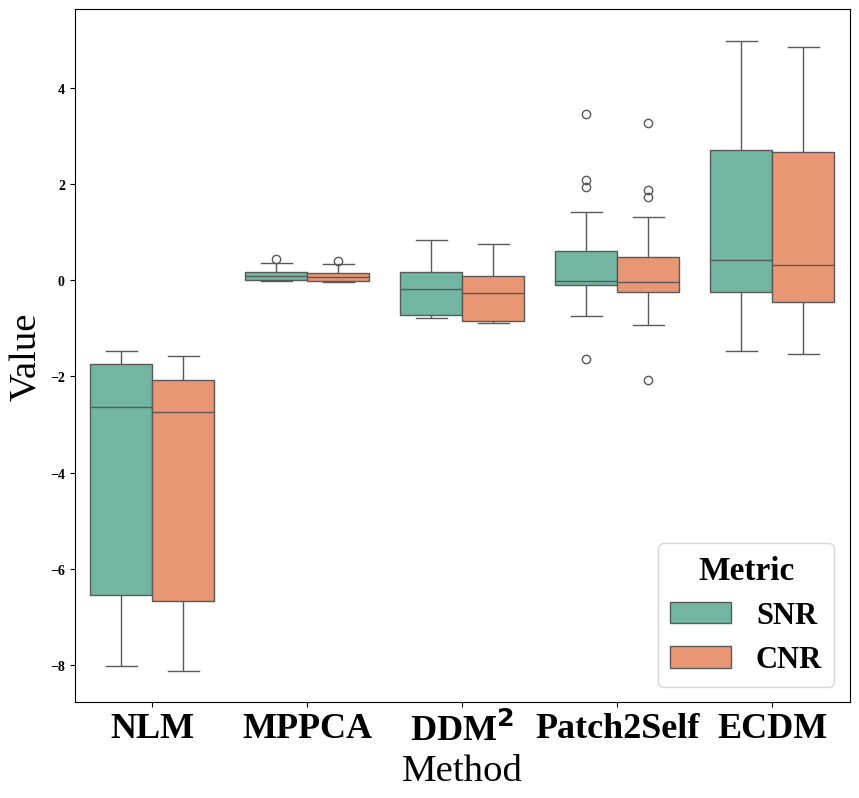

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = {
    'Method': [],
    'Metric': [],
    'Value': []
}

for method in SNRs.keys():
    if method == 'raw':
        continue
    data['Method'].extend([method] * len(SNRs[method]) * 2)  # For SNR and CNR
    data['Metric'].extend(['SNR'] * len(SNRs[method]) + ['CNR'] * len(CNRs[method]))
    data['Value'].extend(SNRs[method])
    data['Value'].extend(CNRs[method])

# Convert the data dictionary to a DataFrame
df_diff = pd.DataFrame(data)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Liberation Serif'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['figure.figsize'] = (7, 6)

# Create the boxplot
plt.figure(figsize=(10, 9))
ax = sns.boxplot(x="Method", y="Value", hue="Metric", data=df_diff, palette="Set2")
ax.set_xlabel('Method', fontsize=28)
ax.set_ylabel('Value', fontsize=28)


# Move the legend to the bottom-right corner
ax.legend(title='Metric', title_fontsize=24, fontsize=22, loc='lower right')

# Save and display the plot
plt.savefig('boxplot.png', dpi=1200)
plt.show()
